## Sensitivity of Concentration to Rate Constant and Initial Condition

jbr book reference: [Figure A.3](https://sites.engineering.ucsb.edu/~jbraw/chemreacfun/fig-html/appendix/fig-A-3.html)

Reaction is $A \xrightarrow[]{k_1} B$

Analytical solution:
$$
c_A(t) = c_{A0}e^{-k_1t}
$$
Sensitivity:
$$
\begin{eqnarray}
\frac{dc_A}{dk_1} &=& -tc_{A0}e^{-k_1t} \\
\frac{dc_A}{dc_{A0}} &=& e^{-k_1t}
\end{eqnarray}
$$
In this example, $c_{A0} = 2\;mol/L$, $k_1 = 1\;min^{-1}$

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyomo.environ as pyo
from kipet import KipetModel
from kipet.library.core_methods.EstimabilityAnalyzer import *

In [30]:
# Though the sensitivity calculation doesn't need data, in KIPET sensitivity is part of Estimability routine 
# which needs concentration data. So the concentration data is simulated first prior to getting sensitivity
kipet_model = KipetModel()

r1 = kipet_model.new_reaction('rxn1')
    
r1.add_component('A', state = 'concentration', init = 2.0)
r1.add_parameter('k1', init = 1.0)
    
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']
    return exprs

r1.add_equations(rule_odes)
r1.set_times(0.0, 10.0)

In [31]:
r1.settings.collocation.nfe = 60
r1.settings.collocation.ncp = 1
r1.settings.collocation.scheme = 'LAGRANGE-RADAU'
r1.settings.solver.linear_solver = 'ma27'
r1.simulate()

times are: <class 'tuple'>


In [32]:
# data
C_data = r1.results.Z
C_data

,A
0.000000,2.000000
0.166667,1.714285
0.333333,1.469388
0.500000,1.259475
0.666667,1.079550
...,...
9.333333,0.000356
9.500000,0.000306
9.666667,0.000262
9.833333,0.000224


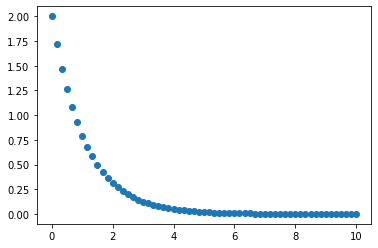

In [33]:
fig, ax = plt.subplots()
ax.scatter(C_data.index, C_data['A'])

In [101]:
# build the model again for getting sensitivity
kipet_model = KipetModel()

r1 = kipet_model.new_reaction('rxn1')
    
r1.add_component('A', state = 'concentration', init = 2.0)

r1.add_parameter('k1', init = 1.0, bounds = (0.1, 10)) # rate constant
r1.add_parameter('ca0', init = 2.0, bounds = (0.0, 5.0)) # initial condition listed as parameters since we want sensitivity w.r.t ca0

def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']
    return exprs

r1.add_equations(rule_odes)
r1.set_times(0.0, 10.0)

r1.add_dataset('C_data', category = 'concentration', data = C_data)

In [102]:
r1.create_pyomo_model()

times are: <class 'tuple'>
0.0 10.0
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (sigma) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/paperspace/my_pyenvs/kipetenv/lib/python3.7/site-
    packages/Pyomo-5.7.1-py3.7-linux-x86_64.egg/pyomo/core/base/param.py:640)


In [103]:
# specify values of parameters at which sensitivity is desired
r1.model.P['k1'].value = 1.0
r1.model.P['ca0'].value = 2.0

# we need an explicit constraint for conc(A) at time 0 = ca0
r1.model.ca0_cons = pyo.Constraint(expr = r1.model.Z[0, 'A'] == r1.model.P['ca0'])

In [104]:
# since we impose a constraint above for conc(A) at time 0, we need to relax the automatic initial condition 
# constraint on conc(A) at time 0 = 2 from the model
r1.model.init_conditions_c['A'].deactivate()
r1.model.init_conditions_c.pprint()

init_conditions_c : Size=1, Index=states, Active=True
    Key : Lower : Body                          : Upper : Active
      A :   0.0 : Z[0.0,A] - init_conditions[A] :   0.0 :  False


In [105]:
e_analyzer = EstimabilityAnalyzer(r1.model)
e_analyzer.apply_discretization('dae.collocation', nfe = 60, ncp = 2, scheme = 'LAGRANGE-RADAU')

In [106]:
sigmas = {'A': 1} # we can just keep this as one since we want unscaled sensitivity
param_uncertainties = {'k1':1,'ca0':1} # we can just keep this as one since we want unscaled sensitivity
dsdp, idx_to_param = e_analyzer.get_sensitivities_for_params(tee=True, sigmasq=sigmas)

W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG]...	[K_AUG_ASL]This problem has no degrees of freedom
Pass the option square_override for the desired behaviour
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zL_out suffix declared, setting zL = 0.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dsdp_in_.in
W[K_AUG]...	[K_AUG_ASL]dsdp for linear C(x) + I*p = 0 override.


[K_AUG] written by D.T. @2018

: dsdp_mode=
dsdp_mode=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 243
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 243
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 0
I[K_AUG]...	[ADJUST_MU]	Warning no relevant info from the problem can predict logmu
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 243, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 844
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 181
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.038068
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 182
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 scaling...
I[K_AUG]...	[ASSM_RHS_DCDP]According to the suffixes declared

In [107]:
# get the sensitivities and compare with analytical sensitivities
tlist = np.array(e_analyzer.model.allmeas_times)
sens = dsdp.copy()
dca_dk1 = sens[:, 0]
dca_dca0 = sens[:, 1]
# analytical sensitivity
dca_dk1_act = -tlist * 2 * np.exp(-tlist) # sensitivity dca/dk1 = -t*ca0*exp(-k1*t), ca0 = 2, k1 = 1
dca_dca0_act = np.exp(-tlist) # sensitivity dca/dca0 = exp(-k1*t), k1 = 1

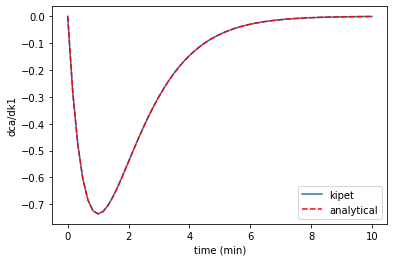

In [108]:
fig, ax = plt.subplots()
ax.plot(tlist, dca_dk1, label = 'kipet')
ax.plot(tlist, dca_dk1_act,'--r', label = 'analytical')
ax.set_xlabel('time (min)')
ax.set_ylabel('dca/dk1')
ax.legend()

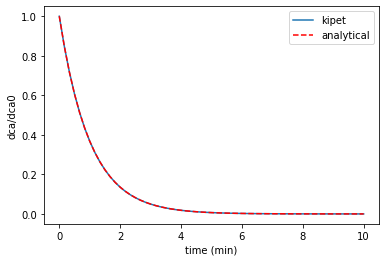

In [109]:
fig, ax = plt.subplots()
ax.plot(tlist, dca_dca0, label = 'kipet')
ax.plot(tlist, dca_dca0_act,'--r', label = 'analytical')
ax.set_xlabel('time (min)')
ax.set_ylabel('dca/dca0')
ax.legend()